In [1]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from PIL import Image
from datasets import load_dataset
from skimage.metrics import (
    structural_similarity as ssim_metric,
    peak_signal_noise_ratio as psnr_metric,
    normalized_root_mse as nrmse_metric,
)
from pytorch_fid import fid_score
from ptflops import get_model_complexity_info
import math
import gc
from tqdm import tqdm
from PIL import Image

# 1) Stream the HF dataset
stream_ds = load_dataset(
    "lerobot/aloha_sim_insertion_human_image",
    split="train",
    streaming=True,
)

# 2) Reservoir‐sample 40 for train, first for test
it = iter(stream_ds)
test_ex = next(it)
train_reservoir = []
for i, ex in enumerate(it):
    if i < 40:
        train_reservoir.append(ex)
    else:
        j = random.randint(0, i)
        if j < 40:
            train_reservoir[j] = ex

# 3) Extract numpy arrays and normalize
img_key = "observation.images.top"
test_images  = [np.array(test_ex[img_key], np.float32) / 255.0]
train_images = [np.array(ex[img_key],    np.float32) / 255.0 for ex in train_reservoir]


/home/bc5080/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

class NumpyImageDataset(Dataset):
    def __init__(self, image_list, transform=None):
        # image_list: list of NumPy arrays shape [H,W] or [H,W,C], dtype float32 in [0,1]
        self.images = image_list
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        arr = self.images[idx]  # float32 [0,1]
        # convert to uint8 PIL Image
        img = (arr * 255).clip(0,255).astype(np.uint8)
        pil = Image.fromarray(img)

        if self.transform:
            tensor = self.transform(pil)    # e.g. Grayscale+ToTensor→(1,H,W)
        else:
            # fallback: direct tensor
            if arr.ndim == 2:
                tensor = torch.from_numpy(arr).unsqueeze(0)
            else:
                tensor = torch.from_numpy(arr.transpose(2,0,1))

        return tensor, 0

# now you can pass transform
transform = T.Compose([
    T.Grayscale(num_output_channels=1),  # ensure 1 channel
    T.ToTensor(),
])

train_ds = NumpyImageDataset(train_images, transform=transform)
test_ds  = NumpyImageDataset(test_images,  transform=transform)

trainloader = DataLoader(
    train_ds, batch_size=32, shuffle=True,
    num_workers=4, pin_memory=False
)
testloader = DataLoader(
    test_ds,  batch_size=1, shuffle=False,
    num_workers=4, pin_memory=False
)


In [6]:
orig_size = (480, 640)
compression = 8

# 5) Define the autoencoder
# class CNNAutoencoder(nn.Module):
#     def __init__(self, orig_size=orig_size, compression=compression):
#         super().__init__()
#         self.orig_h, self.orig_w = orig_size
#         self.small_h = self.orig_h // compression
#         self.small_w = self.orig_w // compression
#         self.latent_dim = 128

#         # Encoder: downsample by strides 4 then 2 (total ×8)
#         self.encoder_conv = nn.Sequential(
#             nn.Conv2d(1, 16, 3, stride=4, padding=1),  # → (B,16, small_h/4, small_w/4)
#             nn.ReLU(True),
#             nn.Conv2d(16,32, 3, stride=2, padding=1),  # → (B,32, ceil(small_h/8), ceil(small_w/8))
#             nn.ReLU(True),
#         )
#         # compute conv output dims using ceil
#         self.conv_out_h = (self.small_h + 7) // 8
#         self.conv_out_w = (self.small_w + 7) // 8
#         conv_out_size = 32 * self.conv_out_h * self.conv_out_w

#         # Bottleneck
#         self.fc_enc = nn.Linear(conv_out_size, self.latent_dim)
#         self.fc_dec = nn.Linear(self.latent_dim, conv_out_size)

#         # Decoder: invert stride=2 then stride=4
#         self.decoder_conv = nn.Sequential(
#             nn.ConvTranspose2d(32,16, 3, stride=2, padding=1, output_padding=1),  # ↑2×
#             nn.ReLU(True),
#             nn.ConvTranspose2d(16, 1, 3, stride=4, padding=1, output_padding=3),   # ↑4×
#             nn.Sigmoid(),
#         )

#     def forward(self, x):
#         x_small = F.interpolate(x,
#                                 size=(self.small_h, self.small_w),
#                                 mode='bilinear', align_corners=False)
#         conv = self.encoder_conv(x_small)
#         flat = conv.flatten(1)
#         z = self.fc_enc(flat)
#         dec_flat = self.fc_dec(z)
#         dec = dec_flat.view(-1, 32, self.conv_out_h, self.conv_out_w)
#         x_recon_small = self.decoder_conv(dec)
#         x_recon = F.interpolate(x_recon_small,
#                                 size=(self.orig_h, self.orig_w),
#                                 mode='bilinear', align_corners=False)
#         return x_recon


class DoubleConv(nn.Module):
    """(Conv → BN → LeakyReLU) × 2"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2, inplace=True),
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with MaxPool then DoubleConv"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )
    def forward(self, x):
        return self.pool_conv(x)

class Up(nn.Module):
    """Upscaling then DoubleConv (with skip)"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, in_ch//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x, skip):
        x = self.up(x)
        # pad if necessary
        diffH = skip.size(2) - x.size(2)
        diffW = skip.size(3) - x.size(3)
        if diffH or diffW:
            x = F.pad(x, [diffW//2, diffW - diffW//2, diffH//2, diffH - diffH//2])
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)

class CNNAutoencoder(nn.Module):
    def __init__(self, orig_size=(480,640), compression=8, base_ch=32):
        super().__init__()
        self.orig_h, self.orig_w = orig_size
        self.small_h = self.orig_h // compression
        self.small_w = self.orig_w // compression

        # encoder path, channels: 32→64→128→256
        self.down0 = DoubleConv(1,      base_ch)         # 32
        self.down1 = Down(base_ch,      base_ch*2)       # 64
        self.down2 = Down(base_ch*2,    base_ch*4)       # 128
        self.down3 = Down(base_ch*4,    base_ch*8)       # 256

        # decoder path
        self.up3   = Up(base_ch*8,      base_ch*4)
        self.up2   = Up(base_ch*4,      base_ch*2)
        self.up1   = Up(base_ch*2,      base_ch)

        self.final = nn.Sequential(
            nn.Conv2d(base_ch, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x_small = F.interpolate(x, (self.small_h, self.small_w),
                                mode='bilinear', align_corners=False)
        x1 = self.down0(x_small)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        y3 = self.up3(x4, x3)
        y2 = self.up2(y3, x2)
        y1 = self.up1(y2, x1)
        out = self.final(y1)
        return F.interpolate(out, (self.orig_h, self.orig_w),
                             mode='bilinear', align_corners=False)



# 6) Setup device, model, loss, optimizer
def get_device():
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        return torch.device("mps")
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

device    = get_device()
model     = CNNAutoencoder(orig_size=orig_size, compression=compression).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


train_losses = []
val_losses   = []
n_epochs = 100

# 7) Training + Validation 
for epoch in range(1, n_epochs + 1):
    # — TRAINING —
    model.train()
    epoch_loss = 0.0
    for imgs, _ in trainloader:
        imgs  = imgs.to(device, non_blocking=True)
        recon = model(imgs)
        loss  = criterion(recon, imgs)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        del imgs, recon, loss

    avg_train = epoch_loss / len(trainloader)
    train_losses.append(avg_train)

    # — VALIDATION —
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, _ in testloader:
            imgs  = imgs.to(device, non_blocking=True)
            recon = model(imgs)
            val_loss += criterion(recon, imgs).item()
            del imgs, recon

    avg_val = val_loss / len(testloader)
    val_losses.append(avg_val)

    torch.cuda.empty_cache()
    gc.collect()

    print(f"Epoch {epoch}/{n_epochs} — Train: {avg_train:.4f} | Val: {avg_val:.4f}")


# 8) Evaluation (PSNR, SSIM, NRMSE, FID)
model.eval()
h = orig_size[0] // compression
w = orig_size[1] // compression
real_dir, fake_dir = "fid_temp/real", "fid_temp/fake"
os.makedirs(real_dir, exist_ok=True)
os.makedirs(fake_dir, exist_ok=True)

psnrs, ssims, nrmses = [], [], []
with torch.no_grad():
    for idx, (imgs, _) in enumerate(testloader):
        imgs  = imgs.to(device)
        recon = model(imgs)

        orig = F.interpolate(
            imgs, size=(h, w),
            mode='bilinear', align_corners=False
        )
        out  = F.interpolate(
            recon, size=(h, w),
            mode='bilinear', align_corners=False
        )

        save_image(orig[0], f"{real_dir}/orig_c{compression}_{idx}.png")
        save_image(out[0],  f"{fake_dir}/recon_c{compression}_{idx}.png")

        o_np = orig[0,0].cpu().numpy()
        r_np = out[0,0].cpu().numpy()
        psnrs.append(psnr_metric(o_np, r_np, data_range=1.0))
        ssims.append(ssim_metric(o_np, r_np, data_range=1.0))
        nrmses.append(nrmse_metric(o_np, r_np))

fid_val = fid_score.calculate_fid_given_paths(
    [real_dir, fake_dir],
    batch_size=1, device=device, dims=2048, num_workers=4
)

print("=== Evaluation ===")
print(f"PSNR:   {np.mean(psnrs):.2f}")
print(f"SSIM:   {np.mean(ssims):.4f}")
print(f"NRMSE:  {np.mean(nrmses):.4f}")
print(f"FID:    {fid_val:.2f}")

# 9) Complexity
macs, params = get_model_complexity_info(
    model, (1, orig_size[0], orig_size[1]),
    as_strings=True, print_per_layer_stat=False
)

print(f"[ptflops] MACs (FLOPs): {macs}")
print(f"[ptflops] Parameters: {params}")


Epoch 1/100 — Train: 0.1701 | Val: 0.1837
Epoch 2/100 — Train: 0.1316 | Val: 0.1761
Epoch 3/100 — Train: 0.1139 | Val: 0.1662
Epoch 4/100 — Train: 0.1012 | Val: 0.1564
Epoch 5/100 — Train: 0.0928 | Val: 0.1473
Epoch 6/100 — Train: 0.0848 | Val: 0.1404
Epoch 7/100 — Train: 0.0797 | Val: 0.1411
Epoch 8/100 — Train: 0.0753 | Val: 0.1301
Epoch 9/100 — Train: 0.0722 | Val: 0.1333
Epoch 10/100 — Train: 0.0692 | Val: 0.1279
Epoch 11/100 — Train: 0.0665 | Val: 0.1444
Epoch 12/100 — Train: 0.0641 | Val: 0.1608
Epoch 13/100 — Train: 0.0617 | Val: 0.1788
Epoch 14/100 — Train: 0.0598 | Val: 0.1736
Epoch 15/100 — Train: 0.0574 | Val: 0.1423
Epoch 16/100 — Train: 0.0555 | Val: 0.1321
Epoch 17/100 — Train: 0.0534 | Val: 0.1145
Epoch 18/100 — Train: 0.0519 | Val: 0.0941
Epoch 19/100 — Train: 0.0499 | Val: 0.0857
Epoch 20/100 — Train: 0.0483 | Val: 0.0826
Epoch 21/100 — Train: 0.0465 | Val: 0.0767
Epoch 22/100 — Train: 0.0449 | Val: 0.0715
Epoch 23/100 — Train: 0.0436 | Val: 0.0674
Epoch 24/100 — Train

100%|██████████| 3/3 [00:00<00:00, 13.97it/s]


=== Evaluation ===
PSNR:   24.48
SSIM:   0.6319
NRMSE:  0.2350
FID:    87.97
[ptflops] MACs (FLOPs): 758.34 MMac
[ptflops] Parameters: 1.93 M


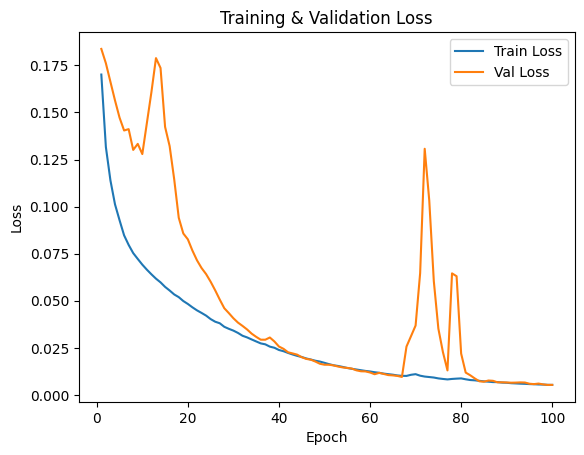

In [7]:
import matplotlib.pyplot as plt

epochs = range(1, n_epochs+1)
plt.figure()
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs,   val_losses,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()


Times 2
=== Evaluation ===
PSNR:   25.08
SSIM:   0.5030
NRMSE:  0.2217
FID:    383.66
[ptflops] MACs (FLOPs): 12.24 GMac
[ptflops] Parameters: 1.93 M

Times 4
=== Evaluation ===
PSNR:   28.24
SSIM:   0.5592
NRMSE:  0.1546
FID:    223.78
[ptflops] MACs (FLOPs): 3.06 GMac
[ptflops] Parameters: 1.93 M

Times 8
=== Evaluation ===
PSNR:   24.48
SSIM:   0.6319
NRMSE:  0.2350
FID:    87.97
[ptflops] MACs (FLOPs): 758.34 MMac
[ptflops] Parameters: 1.93 M